In [1]:
from collections import OrderedDict
import configparser
from functools import partial
import time
import numpy as np
from shapely import Polygon
import math
from typing import Any
from matplotlib.backend_bases import MouseEvent, MouseButton
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import logging
from shapely import Point, Polygon
from typing import Mapping

import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))


from bbtoolkit.dynamics.callbacks.viz import ArtistCallback


import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)


In [2]:
class TimerPlotter(ArtistCallback):
    def __init__(self, coords: tuple[float, float]):
        super().__init__()
        self.coords = coords

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['time_ax'] = cache.fig.add_subplot(cache.gc[:1, 1])
        self.requires = ['time_ax', 'dynamics_params']
        super().set_cache(cache, on_repeat)

    def plot(self):
        self.time_ax.text(*self.coords, f'Time: {(self.dynamics_params.step)*self.dynamics_params.dt : .2f} s')

    def on_plot(self):
        self.plot()

    def on_clean(self):
        self.time_ax.clear()
        self.time_ax.set_axis_off()


class PolarCirclePlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['main_ax'] = cache.fig.add_subplot(cache.gc[:6, :], projection='polar')
        self.requires = [
            'main_ax',
            'movement_params',
            'fig'
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        if self.movement_params.rotate_target is not None:
            self.main_ax.plot(
                [
                    self.movement_params.rotate_target,
                    self.movement_params.rotate_target
                ],
                [0, 1],
                marker='o'
            )
        if self.movement_params.direction is not None:
            self.main_ax.plot(
                [
                    self.movement_params.direction,
                    self.movement_params.direction
                ],
                [0, 1],
                marker='o',
                color='red'
            )

    def on_clean(self):
        self.main_ax.clear()


class MouseEventCallback(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'fig',
            'dynamics_params',
            'movement_params',
            'click_params',
            'main_ax'
        ]
        super().set_cache(cache, on_repeat)
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_click(self, event: MouseEvent):

        if event.inaxes is self.main_ax:

            self.click_params.xy_data = (event.xdata, event.ydata)
            self.movement_params.rotate_target = event.xdata

    def on_copy(self):
        self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    def on_load(self):
        self.on_copy()

In [3]:
from bbtoolkit.models.bb.utils import activity2rate, connectivity_config2dict
from bbtoolkit.structures.tensorgroups import NamedTensor, TensorGroup, dict2directed_tensor
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup
from bbtoolkit.structures.tensorgroups import DirectedTensor, DirectedTensorGroup


n_hd_neurons = 100

activity = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read('../cfg/connectivity/main.ini')

configdict = connectivity_config2dict(config)
connections = dict2directed_tensor(configdict)
connectivity = DirectedTensorGroup(*connections)

connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring1',
        weights=connectivity.hd.to.hd
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring2',
        weights=connectivity.hd.to.hd
    )
)


connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring2',
        to='hd_ring1',
        weights=dict(phi=5)
    )
)
connectivity.add_tensor(
    DirectedTensor(
        from_='hd_ring1',
        to='hd_ring2',
        weights=dict(phi=-3)
    )
)

rates = activity2rate(activity, connectivity)

k_ratio = TensorGroup(
    NamedTensor('hd_ring1', np.zeros((n_hd_neurons, 1))),
    NamedTensor('hd_ring2', np.zeros((n_hd_neurons, 1))),
)

In [28]:
from bbtoolkit.dynamics.callbacks import BaseCallback
from bbtoolkit.structures import DotDict
from bbtoolkit.structures.attractors import LoopAttractor
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d
from bbtoolkit.utils.math import circular_gaussian
from typing import Callable


class HDCallback(BaseCallback):
    def __init__(
        self,
        attractor,
        init_timesteps: int = 30,
        hd_cue_scale: float = 60,
        hd_cue_generator: Callable[[float, int], np.ndarray] = None,
        background_drive_generator: Callable[[], tuple[np.ndarray, np.ndarray]] = None
    ):
        super().__init__()
        self.init_timesteps = init_timesteps
        self.hd_cue_scale = hd_cue_scale
        self.hd_cue_generator = hd_cue_generator if hd_cue_generator is not None else circular_gaussian
        # self.background_drive_generator = background_drive_generator
        if background_drive_generator is None:
            def background_drive_generator():
                return (
                    8*(5 + np.random.rand(self.rates.hd_ring2.shape[0], 1)),
                    2*np.random.rand(self.rates.hd_ring1.shape[0], 1)
                )
        self.background_drive_generator = background_drive_generator

        self.attractor = attractor
        self.kernel = self.attractor.kernel
        self.hd_estim = None
        self.hd_cue_report = True

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'dynamics_params',  # Dynamic parameters including dt, mode, and step.
            'movement_params',  # Movement parameters including position and direction.
            'k_ratio',  # Ratio of excitation/inhibition for HD cells.
            'activity',  # Neural activity levels.
            'connectivity',  # Connectivity matrices between neural populations.
            'rates',  # Firing rates of neurons.
            'additive_kernel',  # Additive kernel for attractor.
            'hd_cue_params',  # Parameters for HD cue presentation.
        ]
        cache['additive_kernel'] = np.zeros((len(cache.rates.hd_ring2),))
        cache['hd_cue_params'] = DotDict(
            total_steps=self.init_timesteps,
            cue = self.hd_cue_scale*self.hd_cue_generator(
                cache.movement_params.direction,
                len(cache.rates.hd_ring1)
            )
        )
        super().set_cache(cache, on_repeat)
        self.dt = self.dynamics_params.dt

    def on_step_begin(self, step: int):

        if self.hd_cue_params.total_steps != 0:

            if self.hd_cue_report:
                logging.debug(f'HD cue initiated for {self.hd_cue_params.total_steps} steps')
                self.hd_cue_report = False

            self.hd_cue_params.total_steps -= 1
            self.hd_cue_params.cue = self.hd_cue_scale*circular_gaussian(
                self.movement_params.direction,
                len(self.rates.hd_ring1)
            )
        else:
            if not np.all(self.hd_cue_params.cue == 0):
                logging.debug('HD cue removed')
                self.hd_cue_report = True
                self.hd_cue_params.cue *= 0

        self.attractor.kernel = (
            self.kernel[0],
            (self.kernel[1] + self.additive_kernel)
        )

        excitatory_bakground_drive, inhibitory_bakground_drive  = self.background_drive_generator()

        state = self.attractor(self.rates.hd_ring1.T, self.rates.hd_ring2.T)
        ring1_rate, ring2_rate = state.values()
        ring1_rate, ring2_rate = ring1_rate.T, ring2_rate.T

        self.k_ratio.hd_ring1 = (
            - self.activity.hd_ring1
            + self.connectivity.hd_ring2.to.hd_ring1['phi']*ring1_rate
            + inhibitory_bakground_drive
            + self.hd_cue_params.cue[:, None]
        )
        self.k_ratio.hd_ring2 = (
            - self.activity.hd_ring2
            + self.connectivity.hd_ring1.to.hd_ring2['phi']*ring2_rate
            + excitatory_bakground_drive
        )

        self.activity.hd_ring1 += self.dt/self.connectivity.hd_ring1.to.hd_ring1['tau']*self.k_ratio.hd_ring1
        self.activity.hd_ring2 += self.dt/self.connectivity.hd_ring2.to.hd_ring2['tau']*self.k_ratio.hd_ring2

        self.rates.hd_ring1 = 1/(1 + np.exp(-2*self.connectivity.hd_ring1.to.hd_ring1['beta']*(self.activity.hd_ring1 - self.connectivity.hd_ring1.to.hd_ring1['alpha'])))
        self.rates.hd_ring2 = 1/(1 + np.exp(-2*self.connectivity.hd_ring2.to.hd_ring2['beta']*(self.activity.hd_ring2 - self.connectivity.hd_ring2.to.hd_ring2['alpha'])))

        if self.hd_cue_params.total_steps == 0:
            popmax = np.where(self.rates.hd_ring1 == np.max(self.rates.hd_ring1))[0][0]
            hd_estim = popmax*2*np.pi/(len(self.rates.hd_ring1) - 1) % (2*np.pi)
            self.movement_params.direction = hd_estim


In [5]:
class HDPlotter(ArtistCallback):
    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        cache['hd_ax_1'] = cache.fig.add_subplot(cache.gc[6:9, :])
        cache['hd_ax_2'] = cache.fig.add_subplot(cache.gc[9:, :])
        self.requires = [
            'hd_ax_1',
            'hd_ax_2',
            'fig',
            'rates',
            'activity',
            'k_ratio',
            'movement_params',
        ]
        super().set_cache(cache, on_repeat)

    def on_plot(self):
        self.hd_ax_1.plot(
            self.rates.hd_ring1,
            '-'
        )
        self.hd_ax_2.plot(
            self.rates.hd_ring2,
            '-'
        )

    def on_clean(self):
        self.hd_ax_1.clear()
        self.hd_ax_1.set_ylim(0, 1)
        self.hd_ax_2.clear()
        self.hd_ax_2.set_ylim(0, 1)

In [195]:
from bbtoolkit.structures import DotDict
from typing import Callable


class RotationAdjustingCallback(BaseCallback):
    def __init__(
        self,
        init_timesteps: int = 30,
        delta_phi: np.ndarray = None,
        kernel_func: Callable[[float], np.ndarray] = None,
        init_angle: float = np.pi/2
    ):
        self.init_timesteps = init_timesteps
        self.step = init_timesteps
        self.reset = True

        self.delta_phi = np.linspace(0, 1, 101)[1:][::-1] if delta_phi is None else delta_phi

        self.delta_phi_index = 0
        self.kernel_func = kernel_func
        self.init_angle = init_angle
        self.final_massage = False

        super().__init__()

    def set_cache(self, cache: Mapping, on_repeat: str = 'raise'):
        self.requires = [
            'movement_params',
            'dynamics_params',
            'simulation_params',
            'rotation_log',
            'additive_kernel',
            'rates',
            'hd_cue_params',
        ]
        cache['rotation_log'] = DotDict()
        super().set_cache(cache, on_repeat)
        if self.kernel_func is None:

            def kernel_func(phi: float) -> np.ndarray:
                return phi*gaussian_kernel_1d(len(self.rates.hd_ring2), center=0.8, sigma=0.15)

            self.kernel_func = kernel_func

    def on_step_end(self, step: int):
        if self.delta_phi_index == len(self.delta_phi) - 1 or self.delta_phi_index == - 1:
            if not self.final_massage:
                self.final_massage = True
                logging.debug('All speed phis have been tested; Simulation will be completed at the end of the current cycle...')
            self.simulation_params.finished = True
            raise StopIteration
        else:
            if self.reset:
                if self.step != 0:
                    self.step -= 1
                    self.cache.additive_kernel *= 0
                else:
                    self.reset = False
                    self.step = self.init_timesteps
                    self.cache.additive_kernel *= 0
                    self.cache.additive_kernel += self.kernel_func(self.delta_phi[self.delta_phi_index])
                    logging.debug('Head direction cue set; New kernel function created')
            else:
                if self.delta_phi[self.delta_phi_index] not in self.rotation_log:
                    logging.debug(f'Testing speed phi ({100 * self.delta_phi_index / len(self.delta_phi) : .3f}%): {self.delta_phi[self.delta_phi_index]}')
                    self.rotation_log[self.delta_phi[self.delta_phi_index]] = DotDict(time=list(), direction=list())

                self.rotation_log[self.delta_phi[self.delta_phi_index]].time.append(self.dynamics_params.step)
                self.rotation_log[self.delta_phi[self.delta_phi_index]].direction.append(self.movement_params.direction)

                if len(self.rotation_log[self.delta_phi[self.delta_phi_index]].time)*self.dynamics_params.dt > 10:
                    logging.debug('Speed phi is too slow (slower that 2*π/10); Removing records and interupting the simulation...')
                    del self.rotation_log[self.delta_phi[self.delta_phi_index]]
                    self.delta_phi_index = - 1

                if self.delta_phi_index != - 1 and\
                    len(self.rotation_log[self.delta_phi[self.delta_phi_index]].time) > (.5/self.dynamics_params.dt)\
                        and np.isclose(
                            self.movement_params.direction, self.rotation_log[self.delta_phi[self.delta_phi_index]].direction[0],
                            atol=.1
                        ):
                    time = len(self.rotation_log[self.delta_phi[self.delta_phi_index]].time)*self.dynamics_params.dt
                    self.delta_phi_index += 1
                    self.reset = True
                    self.hd_cue_params.total_steps = self.init_timesteps
                    self.movement_params.direction = self.init_angle
                    logging.debug(
                        f'Full circle is complete: {time};'
                        ' Resetting head direction cue'
                    )

In [7]:
from bbtoolkit.utils.datautils import read_pkl


rotation_log = read_pkl(
    '../data/dynamics/rotation_log.pkl'
)
rotation_log2 = read_pkl(
    '../data/dynamics/rotation_log2.pkl'
)

times, phis = [], []
for key in rotation_log:
    times.append(len(rotation_log[key].time))
    phis.append(key)

times, phis = np.array(times), np.array(phis)

times2, phis2 = [], []
for key in rotation_log2:
    times2.append(len(rotation_log2[key].time))
    phis2.append(key)

times2, phis2 = np.array(times2), np.array(phis2)

base_kernel = (
    gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
    gaussian_kernel_1d(100, center=0.8, sigma=0.15)
)

ex_kernel = gaussian_kernel_1d(100, center=0.5, sigma=0.05)

additive_kernel_fun =  lambda phi: phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15)

sigma = lambda x: 1/(1 + np.exp(-2*.1*(x - 30)))


In [183]:
def compile_function_from_string(function_string: str) -> Callable:
    """
    Compiles and returns a function from a given string representation of the function.

    Args:
        function_string (str): A string representation of a Python function.

    Returns:
        Callable: The compiled function ready to be called.
    """
    # Prepare a dictionary to serve as the local scope for exec()
    local_scope = {}

    # Compile and execute the string as Python code, specifying local scope
    exec(function_string, globals(), local_scope)

    # Extract the function name from the string
    function_name = [line for line in function_string.splitlines() if line.startswith("def")][0].split()[1].split('(')[0]

    # Return the function using its name
    return local_scope[function_name]


def generate_poly_func(N: int) -> Callable:
    """
    Generates a polynomial function of degree N.

    Args:
        N (int): The degree of the polynomial function to generate.

    Returns:
        Callable: A polynomial function of degree N. The function takes N+1 arguments:
                  the variable x followed by the coefficients of the polynomial starting
                  from the highest degree to the constant term.
    """
    # Start of the function definition
    func_def = f"def poly_func{N}(x"

    # Adding parameters a, b, c, ..., based on N
    for i in range(N + 1, 0, -1):
        func_def += f", {chr(97 + N + 1 - i)}"

    # Closing the parameter list and starting the function body
    func_def += "):\n    return "

    # Adding the polynomial terms
    for i in range(N, 0, -1):
        if i > 1:
            func_def += f"{chr(97 + N - i)} * x**{i} + "
        else:
            func_def += f"{chr(97 + N - i)} * x"

    # Adding the constant term
    if N >= 1:
        func_def += f" + {chr(97 + N)}"

    # Executing the function definition
    return compile_function_from_string(func_def)


def find_outliers(
    data: np.ndarray,
    window_size: int = 15,
    threshold: float = 3.,
    accept_rate: float = .5
) -> list[int]:
    """
    Identifies outliers in a dataset using a sliding window approach and z-score calculation.

    Args:
        data (np.ndarray): The input dataset as a numpy array.
        window_size (int, optional): The size of the sliding window. Defaults to 15.
        threshold (float, optional): The z-score threshold to consider a data point as an outlier. Defaults to 3.
        accept_rate (float, optional): The rate at which a data point is considered an outlier within the window. Defaults to 0.5.

    Returns:
        list[int]: A list of indices in the dataset that are considered outliers.

    """
    rates = dict(zip(range(len(data)), np.zeros(len(data))))
    outliers = list()

    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        window_mean = np.mean(window)
        window_std = np.std(window)
        for j, elem in enumerate(window):
            z_score = np.abs((elem - window_mean)/window_std)
            if z_score > threshold:
                rates[i + j] += 1/window_size

    for val, rate in rates.items():
        if rate > accept_rate:
            outliers.append(val)

    return outliers


def find_repeating_indices(arr: np.ndarray, threshold: int) -> list[list[int]]:
    # Check if the input is a 1D numpy array
    if arr.ndim != 1:
        raise ValueError("Input must be a 1D numpy array")

    # Find unique elements and their counts
    unique_elements, counts = np.unique(arr, return_counts=True)

    # Filter elements that appear more than the threshold
    repeating_elements = unique_elements[counts > threshold]

    # Find indices of repeating elements that meet the threshold
    indices_of_repeating = [np.where(np.isclose(arr, element))[0].tolist() for element in repeating_elements if len(np.where(arr == element)[0]) > threshold]

    return indices_of_repeating


def remove_indices(arr: np.ndarray, indices: list[int]) -> np.ndarray:
    """
    Removes elements from an array at the specified indices.

    Args:
        arr (np.ndarray): The input array.
        indices (list[int]): A list of indices of the elements to be removed.

    Returns:
        np.ndarray: An array with the elements at the specified indices removed.
    """
    # Ensure indices is a set to avoid duplicates
    indices_to_remove = set(indices)
    # Create a mask for all elements that are not in indices_to_remove
    mask = np.array([i not in indices_to_remove for i in range(len(arr))])
    # Return the array with elements at the specified indices removed
    return arr[mask]

In [9]:
rotation_log = read_pkl(
    '../data/dynamics/rotation_log.pkl'
)

times, phis = [], []
for key in rotation_log:
    times.append(len(rotation_log[key].time))
    phis.append(key)

times, phis = np.array(times), np.array(phis)


2024-06-28 18:03:43 - DEBUG - Repeating values detected (4): [5, 7, 37, 38]
2024-06-28 18:03:43 - DEBUG - Outliers detected (4): [16, 45, 58, 72]
2024-06-28 18:03:43 - WARNING - Values are out of fitted range: 0.06 - 1.0


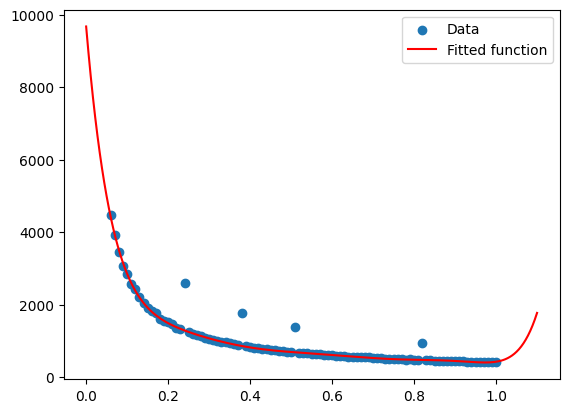

In [225]:
from bbtoolkit.utils.datautils import Copyable, WritablePickle
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

class PolyApproximation(WritablePickle, Copyable):
    """
    A class for polynomial approximation of data, with outlier removal and data rescaling capabilities.

    Attributes:
        order (int): The order of the polynomial function used for approximation.
        **kwargs: Arbitrary keyword arguments passed to the outlier detection function.

    Methods:
        fit(x, y): Fits the polynomial model to the data, excluding outliers.
        rescale(y, direction): Rescales the data between 0 and 1 or inversely, based on the range of y values.
        __call__(x): Evaluates the polynomial function at given x values.

    Raises:
        ValueError: If model parameters or covariance matrix are accessed before fitting the model,
                    or if the range is not defined when rescaling.
    """
    def __init__(
        self,
        order: int = 8,
        **kwargs
    ):
        """
        Initializes the PolyApproximation instance with a specified polynomial order and outlier detection parameters.

        Args:
            order (int, optional): The order of the polynomial function for approximation. Defaults to 8.
            **kwargs: Additional keyword arguments for the outlier detection function.
        """
        self.func = generate_poly_func(order)
        kwargs.setdefault('threshold', 2)
        self.find_outliers = partial(find_outliers, **kwargs)
        self.range = None
        self._params = None
        self._cov = None

    @property
    def params(self):
        """
        The parameters of the fitted polynomial model.

        Raises:
            ValueError: If the parameters are accessed before the model is fitted.
        """
        if self._params is None:
            raise ValueError('Parameters are not defined, fit the model first')
        return self._params

    @params.setter
    def params(self, value):
        self._params = value

    @property
    def cov(self):
        """
        The covariance matrix of the fitted polynomial model parameters.

        Raises:
            ValueError: If the covariance matrix is accessed before the model is fitted.
        """
        if self._cov is None:
            raise ValueError('Covariance matrix is not defined, fit the model first')
        return self._cov

    @cov.setter
    def cov(self, value):
        self._cov = value

    def fit(self, x: np.ndarray, y: np.ndarray):
        """
        Fits the polynomial model to the data, excluding outliers.

        Args:
            x (np.ndarray): The independent variable data.
            y (np.ndarray): The dependent variable data.
        """
        outliers = [item for sublist in find_repeating_indices(y, threshold=1) for item in sublist]
        if len(outliers)/len(y) > .5:
            if len(outliers)/len(y) > .9:
                raise ValueError('More than 90% of the data is repeating, not suitable for fitting')

            logging.warning('More than 50% of the data is repeating, probably not suitable for fitting')

        if len(outliers):
            logging.debug(f'Repeating values detected ({len(outliers)}): {outliers}')
            x = remove_indices(x, outliers)
            y = remove_indices(y, outliers)

        outliers = self.find_outliers(y)
        if len(outliers):
            logging.debug(f'Outliers detected ({len(outliers)}): {outliers}')
            x = remove_indices(x, outliers)
            y = remove_indices(y, outliers)

        min_y, max_y = np.min(y), np.max(y)
        self.range = (min_y, max_y, max_y - min_y)
        self.params_range = (np.min(x), np.max(x))
        self.params, self.cov = curve_fit(self.func, x, self.rescale(y))

    def rescale(self, y: np.ndarray, direction: Literal['forward', 'backward'] = 'forward') -> np.ndarray:
        """
        Rescales the data between 0 and 1 or inversely, based on the range of y values.

        Args:
            y (np.ndarray): The data to rescale.
            direction (Literal['forward', 'backward'], optional): The direction of rescaling. Defaults to 'forward'.

        Returns:
            np.ndarray: The rescaled data.

        Raises:
            ValueError: If the range is not defined.
        """
        if self.range is None:
            raise ValueError('Range is not defined')
        if direction == 'forward':
            return (y - self.range[0])/(self.range[2])
        else:
            return y*self.range[2] + self.range[0]

    def __call__(self, x: np.ndarray) -> np.ndarray:
        """
        Evaluates the polynomial function at given x values using the fitted model parameters.

        Args:
            x (np.ndarray): The independent variable data.

        Returns:
            np.ndarray: The evaluated values of the polynomial function.
        """
        if np.min(x) < self.params_range[0] or np.max(x) > self.params_range[1]:
            logging.warning(f'Values are out of fitted range: {self.params_range[0]} - {self.params_range[1]}')

        return self.rescale(self.func(x, *self.params), direction='backward')


poly_approx = PolyApproximation(order=8, window_size=15, threshold=3., accept_rate=.5)
poly_approx.fit(phis, times)

plt.scatter(phis, times, label='Data')

t = np.linspace(1.1, 0, 200)
plt.plot(t, poly_approx(t), label='Fitted function', color='red')

plt.legend()
plt.show()

In [108]:
from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.viz import PlottingCallback
from bbtoolkit.models.bb.callbacks import TimerCallback
from bbtoolkit.models.bb.structures import ClickParameters, DynamicParameters
from bbtoolkit.structures import DotDict
from bbtoolkit.dynamics.callbacks.movement import MovementParameters
from bbtoolkit.structures.attractors import LoopAttractor
from bbtoolkit.structures.attractors.kernels import gaussian_kernel_1d

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib qt

dt = .005

direction = np.pi/2

cache = DotDict()
cache['dynamics_params'] = DynamicParameters(dt, None)
cache['click_params'] = ClickParameters()
cache['movement_params'] = MovementParameters(direction=np.pi/2)
cache['activity'] = activity.copy()
cache['rates'] = rates.copy()
cache['k_ratio'] = k_ratio.copy()
cache['connectivity'] = connectivity.copy()
cache.connectivity.hd_ring1.to.hd_ring2['phi'] = -3
cache.connectivity.hd_ring2.to.hd_ring1['phi'] = 10
cache.connectivity.hd_ring1.to.hd_ring1['alpha'] = 30
cache.connectivity.hd_ring2.to.hd_ring2['alpha'] = 30
cache['simulation_params'] = DotDict(finished=False)

def kernel_func(phi: float) -> np.ndarray:
    return phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15) -\
        phi*gaussian_kernel_1d(100, center=0.2, sigma=0.15)

def kernel_func(phi: float) -> np.ndarray:
    return phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15)


dynamics = DynamicsManager(
    dt,
    callbacks=[
        HDCallback(
            LoopAttractor(
                (
                    gaussian_kernel_1d(100, center=0.5, sigma=0.05)[None, :],
                    (
                        gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                        gaussian_kernel_1d(100, center=0.8, sigma=0.15)
                    )[None, :]
                )
            ),
            init_timesteps=100
        ),
        RotationAdjustingCallback(
            init_timesteps=100,
            # speed_phi=np.linspace(0, .2, 10)[1:][::-1],
        ),
        TimerCallback(),
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                HDPlotter(),
                MouseEventCallback(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ],
    cache=cache
)


for _ in dynamics(lambda steps_per_cycle: not cache.simulation_params.finished):
    print('out: ', _)

2024-06-28 16:18:45 - DEBUG - Loaded backend qtagg version 6.7.0.
2024-06-28 16:18:45 - DEBUG - HD cue initiated for 100 steps
2024-06-28 16:18:50 - DEBUG - HD cue removed
2024-06-28 16:18:50 - DEBUG - Head direction cue set; New kernel function created
2024-06-28 16:18:50 - DEBUG - Testing speed phi ( 0.000%): 1.0


KeyboardInterrupt: 

In [12]:
dynamics.save('../data/dynamics/rotation_adjust_sim.pkl')

AttributeError: Can't pickle local object 'RotationAdjustingCallback.set_cache.<locals>.<lambda>'

In [196]:
def estimate_rotation_speed(
    activity: TensorGroup,
    connectivity: DirectedTensorGroup,
    attractor: LoopAttractor,
    cue_init_timesteps: int = 100,
    hd_cue_scale: float = 60,
    hd_cue_generator: Callable[[float, int], np.ndarray] = None,
    background_drive_generator: Callable[[], tuple[np.ndarray, np.ndarray]] = None,
    delta_phi: np.ndarray = None,
    additive_kernel_func: Callable[[float], np.ndarray] = None,
    dt = .005,
    poly_approx: PolyApproximation = None,
    show: bool = False
) -> PolyApproximation:
    rates = activity2rate(activity, connectivity)
    k_ratio = activity.copy()
    cache = DotDict(
        dynamics_params=DynamicParameters(dt, None),
        movement_params=MovementParameters(direction=np.pi/2),
        activity=activity,
        rates=rates,
        k_ratio=k_ratio,
        connectivity=connectivity,
        simulation_params=DotDict(finished=False),
    )
    plotting = [
        PlottingCallback(
            [
                PolarCirclePlotter(),
                TimerPlotter((0, 0)),
                HDPlotter(),
            ],
            update_rate=5,
            fig_kwargs=dict(figsize=(10, 10)),
            gc_kwargs=dict(nrows=12, ncols=12)
        )
    ] if show else list()
    dynamics = DynamicsManager(
        dt,
        callbacks=[
            HDCallback(
                attractor,
                init_timesteps=cue_init_timesteps,
                hd_cue_scale=hd_cue_scale,
                hd_cue_generator=hd_cue_generator,
                background_drive_generator=background_drive_generator
            ),
            RotationAdjustingCallback(
                init_timesteps=cue_init_timesteps,
                delta_phi=delta_phi,
                kernel_func=additive_kernel_func
            ),
            TimerCallback()
        ] + plotting,
        cache=cache
    )

    def stop_condition(steps_per_cycle):
        return not cache.simulation_params.finished

    for _ in dynamics(stop_condition):
        pass

    if poly_approx is None:
        poly_approx = PolyApproximation(order=8, window_size=15, threshold=3., accept_rate=.5)

    poly_approx.fit(
        np.array(list(dynamics.cache.rotation_log.keys())),
        dt*np.array([len(val.time) for val in dynamics.cache.rotation_log.values()])
    )
    return dynamics, poly_approx

In [226]:
activity2use = activity.copy()
connectivity2use = connectivity.copy()
connectivity2use.hd_ring1.to.hd_ring2['phi'] = -3
connectivity2use.hd_ring2.to.hd_ring1['phi'] = 10
connectivity2use.hd_ring1.to.hd_ring1['alpha'] = 30
connectivity2use.hd_ring2.to.hd_ring2['alpha'] = 30
%matplotlib qt
def kernel_func(phi: float) -> np.ndarray:
    return phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15) -\
        phi*gaussian_kernel_1d(100, center=0.2, sigma=0.15)

def kernel_func(phi: float) -> np.ndarray:
    return phi*gaussian_kernel_1d(100, center=0.8, sigma=0.15)

speed_dynamics, poly_approx = estimate_rotation_speed(
    activity2use,
    connectivity2use,
    LoopAttractor(
        (
            gaussian_kernel_1d(100, center=0.5, sigma=0.05)[None, :],
            (
                gaussian_kernel_1d(100, center=0.2, sigma=0.15) +
                gaussian_kernel_1d(100, center=0.8, sigma=0.15)
            )[None, :]
        )
    ),
    cue_init_timesteps=100,
    hd_cue_scale=60,
    delta_phi=np.linspace(0, 1, 101)[1:][::-1],
    additive_kernel_func=kernel_func,
    dt=.005,
    poly_approx=poly_approx,
    show=False
)

2024-06-28 18:03:52 - DEBUG - Loaded backend qtagg version 6.7.0.
2024-06-28 18:03:52 - DEBUG - HD cue initiated for 100 steps
2024-06-28 18:03:53 - DEBUG - HD cue removed
2024-06-28 18:03:53 - DEBUG - Head direction cue set; New kernel function created
2024-06-28 18:03:53 - DEBUG - Testing speed phi ( 0.000%): 1.0
2024-06-28 18:03:53 - DEBUG - Full circle is complete: 0.795; Resetting head direction cue
2024-06-28 18:03:53 - DEBUG - HD cue initiated for 100 steps
2024-06-28 18:03:54 - DEBUG - HD cue removed
2024-06-28 18:03:54 - DEBUG - Head direction cue set; New kernel function created
2024-06-28 18:03:54 - DEBUG - Testing speed phi ( 1.000%): 0.99
2024-06-28 18:03:55 - DEBUG - Full circle is complete: 0.8300000000000001; Resetting head direction cue
2024-06-28 18:03:55 - DEBUG - HD cue initiated for 100 steps
2024-06-28 18:03:55 - DEBUG - HD cue removed
2024-06-28 18:03:55 - DEBUG - Head direction cue set; New kernel function created
2024-06-28 18:03:55 - DEBUG - Testing speed phi 

2024-06-28 18:10:18 - DEBUG - Loaded backend inline version unknown.


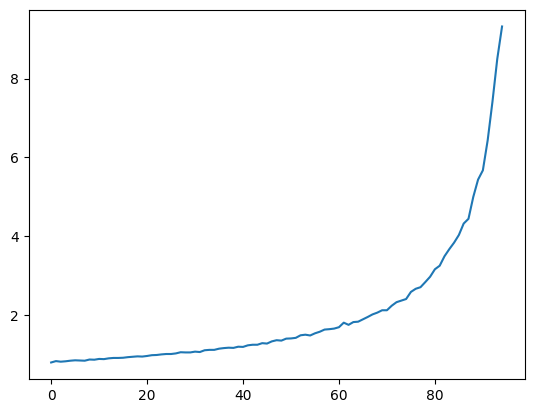

In [227]:
%matplotlib inline
phi = np.array(list(speed_dynamics.cache.rotation_log.keys()))
vals = dt*np.array([len(val.time) for val in speed_dynamics.cache.rotation_log.values()])
plt.plot(vals)

2024-06-28 18:10:26 - DEBUG - Loaded backend inline version unknown.


Text(0.5, 1.0, 'Rotation Speed Estimation for dt = 0.005')

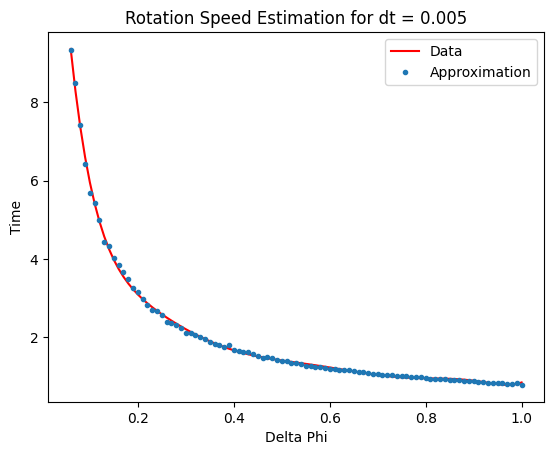

In [228]:
%matplotlib inline
phi = np.array(list(speed_dynamics.cache.rotation_log.keys()))
vals = speed_dynamics.cache.dynamics_params.dt*np.array([len(val.time) for val in speed_dynamics.cache.rotation_log.values()])

plt.plot(phi, poly_approx(phi), '-', color='r')
plt.plot(phi, vals, '.')
plt.xlabel('Delta Phi')
plt.ylabel('Time')
plt.legend([
    'Data',
    'Approximation'
])
plt.title(f'Rotation Speed Estimation for dt = {speed_dynamics.cache.dynamics_params.dt}')

2024-06-28 18:02:58 - DEBUG - Loaded backend inline version unknown.


Text(0.5, 1.0, 'Rotation Speed Estimation for dt = 0.002')

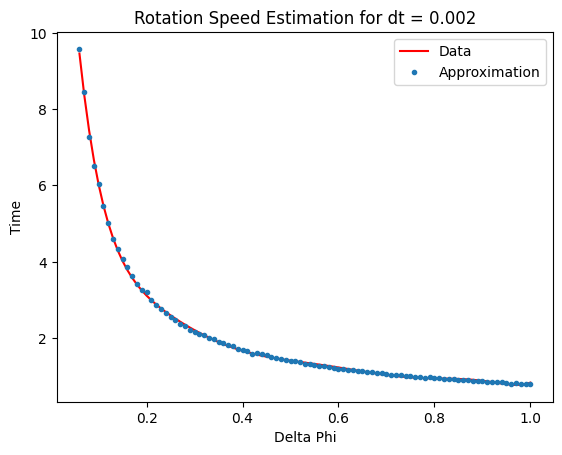

In [224]:
%matplotlib inline
phi = np.array(list(speed_dynamics.cache.rotation_log.keys()))
vals = speed_dynamics.cache.dynamics_params.dt*np.array([len(val.time) for val in speed_dynamics.cache.rotation_log.values()])

plt.plot(phi, poly_approx(phi), '-', color='r')
plt.plot(phi, vals, '.')
plt.xlabel('Delta Phi')
plt.ylabel('Time')
plt.legend([
    'Data',
    'Approximation'
])
plt.title(f'Rotation Speed Estimation for dt = {speed_dynamics.cache.dynamics_params.dt}')

2024-06-28 16:33:15 - DEBUG - Loaded backend inline version unknown.
2024-06-28 16:33:15 - WARNING - Values are out of fitted range: 0.09 - 1.0


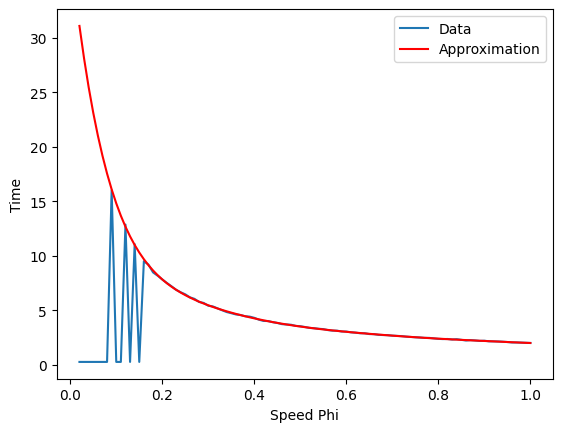

In [127]:
%matplotlib inline
phi = np.array(list(speed_dynamics.cache.rotation_log.keys()))
vals = dt*np.array([len(val.time) for val in speed_dynamics.cache.rotation_log.values()])
plt.plot(phi, vals)
plt.plot(phi, poly_approx(phi), '-', color='r')
plt.xlabel('Speed Phi')
plt.ylabel('Time')
plt.legend([
    'Data',
    'Approximation'
])

2024-06-28 16:03:37 - WARNING - Values are out of fitted range: 0.1 - 1.0


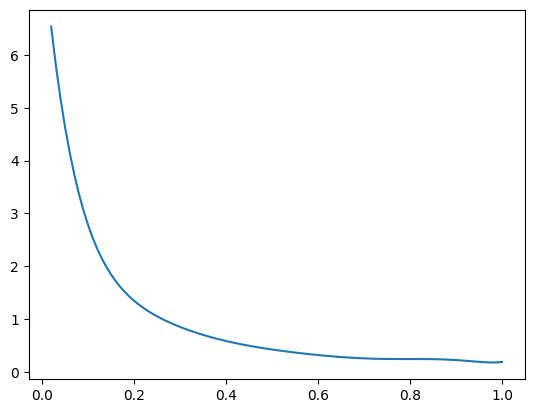

In [88]:
plt.plot(phi, poly_approx(phi))

In [207]:
poly_approx2.range

(1.985, 23.945, 21.96)

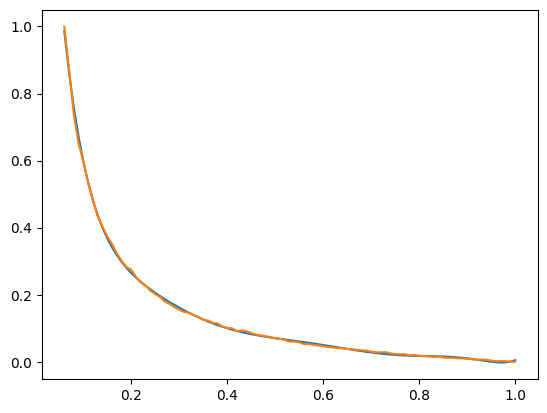

In [217]:
plt.plot(phi, poly_approx.func(phi, *poly_approx2.params))
plt.plot(phi, poly_approx.rescale(0.002*vals/0.005))

2024-06-28 17:29:38 - DEBUG - Loaded backend inline version unknown.


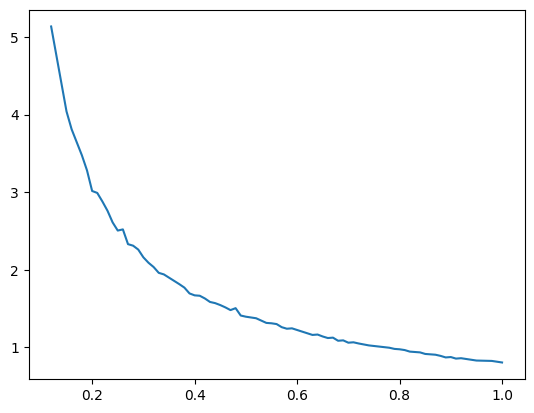

In [177]:
import numpy as np

def find_repeating_indices(arr: np.ndarray, threshold: int) -> list[list[int]]:
    # Check if the input is a 1D numpy array
    if arr.ndim != 1:
        raise ValueError("Input must be a 1D numpy array")

    # Find unique elements and their counts
    unique_elements, counts = np.unique(arr, return_counts=True)

    # Filter elements that appear more than the threshold
    repeating_elements = unique_elements[counts > threshold]

    # Find indices of repeating elements that meet the threshold
    indices_of_repeating = [np.where(np.isclose(arr, element))[0].tolist() for element in repeating_elements if len(np.where(arr == element)[0]) > threshold]

    return indices_of_repeating

%matplotlib inline

outliers = [item for sublist in find_repeating_indices(vals, threshold=1) for item in sublist]

phi1 = remove_indices(phi, outliers)
vals1= remove_indices(vals, outliers)
outliers = find_outliers(vals1, threshold=3)
plt.plot(remove_indices(phi1, outliers), remove_indices(vals1, outliers))

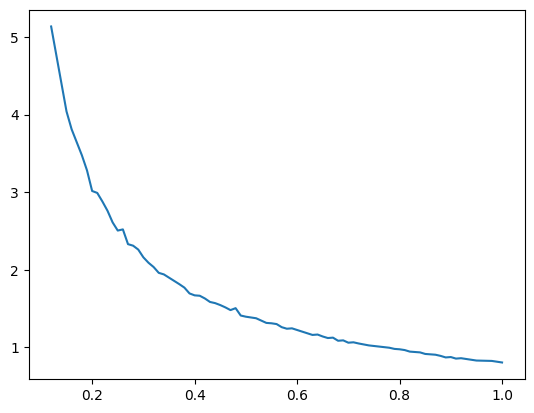

In [178]:
plt.plot(phi1, vals1)

In [67]:
find_outliers(vals, threshold=2)

list

2024-06-28 15:35:48 - DEBUG - Loaded backend inline version unknown.


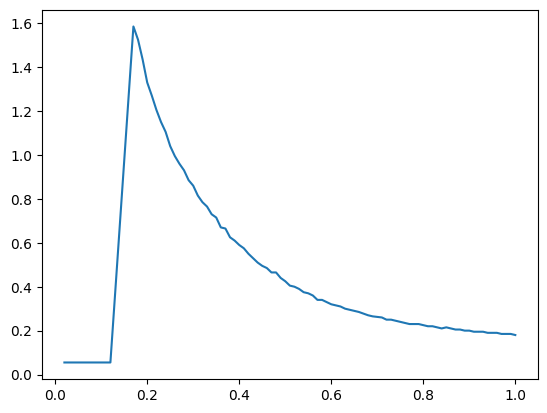

In [72]:
%matplotlib inline
outliers = find_outliers(vals, threshold=1)
plt.plot(remove_indices(phi, outliers), remove_indices(vals, outliers))

In [99]:
from bbtoolkit.utils.datautils import save_pkl


save_pkl(cache.rotation_log, '../data/dynamics/rotation_log2.pkl')

In [13]:
from bbtoolkit.utils.datautils import read_pkl


rotation_log = read_pkl(
    '../data/dynamics/rotation_log.pkl'
)

In [93]:
times2, phis2 = [], []
for key in cache.rotation_log:
    times2.append(len(cache.rotation_log[key].time))
    phis2.append(key)

In [26]:
times, phis = [], []
for key in rotation_log:
    times.append(len(rotation_log[key].time))
    phis.append(key)

NameError: name 'rotation_log' is not defined

In [100]:
rotation_log2 = read_pkl(
    '../data/dynamics/rotation_log2.pkl'
)

2024-06-27 15:58:19 - DEBUG - Loaded backend inline version unknown.


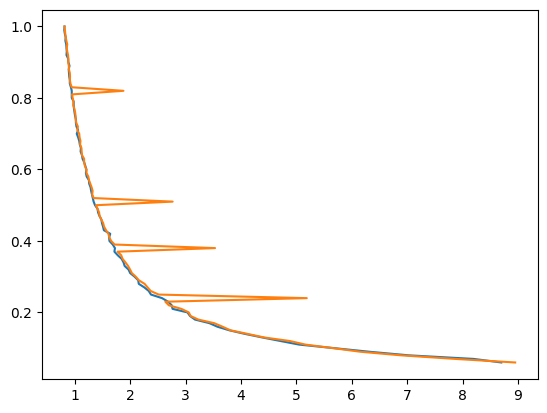

In [98]:
%matplotlib inline
plt.plot(np.array(times2)*0.005, phis2)
plt.plot(
    np.array(times)*0.002, phis
)

2024-06-25 17:28:50 - DEBUG - Loaded backend inline version unknown.


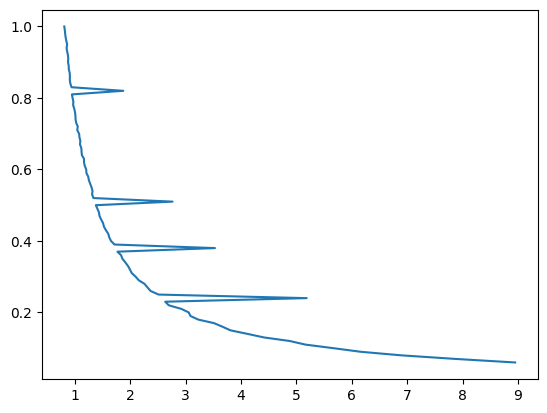

In [20]:
%matplotlib inline
plt.plot(times, phis)

In [ ]:
from typing import Any
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split

class MLRegressor:
    def __init__(self, regressor: BaseEstimator) -> None:
        """
        Initializes the MLRegressor with a given regressor.

        Args:
            regressor (BaseEstimator): A machine learning regressor that follows the scikit-learn regressor interface.
        """
        self.regressor: BaseEstimator = regressor
        self.is_fitted: bool = False

    def fit(self, X: np.ndarray, Y: np.ndarray, test_size: float = 0.2, random_state: int = None) -> None:
        """
        Splits the data into training and testing sets, then fits the regressor on the training set.

        Args:
            X (np.ndarray): The feature matrix.
            Y (np.ndarray): The target variable array.
            test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
            random_state (int, optional): Controls the shuffling applied to the data before applying the split. Defaults to None.
        """
        self.regressor.fit(X, Y)
        self.is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        """
        Makes predictions using the fitted regressor on the provided feature matrix.

        Args:
            X (np.ndarray): The feature matrix for which to make predictions.

        Returns:
            np.ndarray: The predicted values.

        Raises:
            RuntimeError: If the regressor has not been fitted yet.
        """
        if not self.is_fitted:
            raise RuntimeError("The regressor has not been fitted yet. Please call the fit method first.")
        return self.regressor.predict(X)